# Full age comparison

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib
from tqdm import trange

import astropy.stats as aps
from astropy.io import fits

from stardate.lhf import gk_rotation_model
from kinematics_and_rotation.photometric_teff import bprp_to_teff

import aviary as av

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


Load data sets.

Isochrone comparison.

In [3]:
xd = pd.read_csv("xd.csv")

All kinematics.

In [4]:
df = pd.read_csv("../all_rvs.csv")
m = np.isfinite(df.color_teffs.values) & np.isfinite(df.Prot.values) & np.isfinite(df.abs_G.values) & np.isfinite(df.all_vz.values)
df = df.iloc[m]

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Asteroseismic

In [5]:
# Load asteroseismic stars.
ast1 = pd.read_csv("../../data/vanSaders.txt")
# a_prot, a_teff, a_age = ast.period.values, ast.teff.values, ast.AMP_age.values

# Load Gaia-Kepler crossmatch.
with fits.open("../../data/kepler_dr2_1arcsec.fits") as data:
    gaia = pd.DataFrame(data[1].data, dtype="float64")
ast = pd.merge(ast1, gaia, how="left", left_on="KIC", right_on="kepid", suffixes=["_vansaders", ""])
print(np.shape(ast))

def abs_g(m, D):
    """
    m - M = 5log(D) - 5
    M = m - 5log(D) + 5
    """
    return m - 5*np.log10(D) + 5

ast["MG"] = abs_g(ast.phot_g_mean_mag.values, (1./ast.parallax.values)*1e3)

(21, 120)


White dwarf.

In [6]:
wd1 = pd.DataFrame(dict({"kepid": [12456401, 11075611], "age": [3.59, 3.64], "prot": [28.901, 47.340], "teff": [3610.0, 3408.0]}))
wd = pd.merge(wd1, df, how="left", on="kepid", suffixes=["_wd", ""])
print(np.shape(wd))

(2, 206)


Clusters and other asteroseismic (only compare clusters older than 2 Gyr).

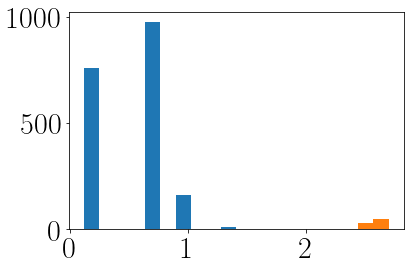

In [7]:
clusters = pd.read_csv("../../data/gyro_clusters_draft-2020April08.csv")
clusters.head()
H, bins, _ = plt.hist(clusters.AGE.values*1e-3, 20, zorder=0);
clusters = clusters.iloc[clusters.AGE.values*1e-3 > 2]
plt.hist(clusters.AGE.values*1e-3, bins, zorder=10);

In [8]:
benchmark = pd.read_csv("../../data/curtis.csv", skiprows=51)

Define kinematic age functions.

In [9]:
def calc_dispersion_bins(teffs, prots, mags, vs, teffrange, protrange, magrange):
    """
    This function is for the total McQuillan sample.
    Calculates dispersions in Teff, Prot, M_G bins.
    
    Args:
        teffs (array): The Teff array.
        prots (array): The Prot array.
        mags (array): The M_G array.
        vs (array): The velocity array.
        teffrange (float): The teff bin-size
        protrange (float): The Prot bin-size
        magrange (float): The M_G bin-size
        
    Returns:
        dispersions (array): The velocity dispersion for each star.
        
    """
    dispersions = np.zeros(len(teffs))
    for i in trange(len(teffs)):
        mask = make_mask([teffs[i], prots[i], mags[i]], [teffs, prots, mags], [teffrange, protrange, magrange])
        vbin = vs[mask]
        dispersions[i] = 1.5*aps.median_absolute_deviation(vbin, ignore_nan=True)
    return dispersions


def make_mask(targets, all_stars, ranges):
    """
    Generic function for binning stars in N-D.
    
    Args:
        targets (array): The properties of the target star (e.g. [teff, prot, mag])
        all_stars (list):  list of arrays of properties for each star.
        ranges (list): The bin sizes.
    """
    ndim = len(targets)
    bounds = []
    m = np.ones(len(all_stars[0]), dtype=bool)
    for i in range(ndim):
        upper_bound = targets[i] + ranges[i]/2.
        lower_bound = targets[i] - ranges[i]/2.
        m &= (lower_bound < all_stars[i]) & (all_stars[i] < upper_bound)
    return m


def calc_dispersion_target(target_teff, target_prot, target_mag, teffs, prots, mags, vels, teffrange, protrange, magrange):
    """
    This function is for calculating dispersions of target stars,  binning in teff, prot and mag.
    
    Args:
        target_teff (float): The Teff of the target star.
        target_prot (float): The prot of the target star.
        target_mag (float): The mag of the target star.
        teffs (array): The Teff array.
        prots (array): The Prot array.
        mags (array): The M_G array.
        vs (array): The velocity array.
        teffrange (float): The teff bin-size
        protrange (float): The Prot bin-size
        magrange (float): The M_G bin-size
        
    Returns:
        dispersions (array): The velocity dispersion for each star.
        
    """
    dispersions = np.zeros(len(target_teff))
    for i in trange(len(target_teff)):
        mask = make_mask([target_teff[i], target_prot[i], target_mag[i]], [teffs, prots, mags], [teffrange, protrange, magrange])
        mask2 = np.isfinite(vels[mask])
        if len(vels[mask][mask2]) > 0:
            dispersions[i] = 1.5*aps.median_absolute_deviation(vels[mask][mask2], ignore_nan=True)
    return dispersions

def calc_dispersion_target_2D(target_teff, target_prot, teffs, prots, vels, teffrange, protrange):
    """
    This function is for calculating dispersions of target stars,  binning in teff and prot.
    
    Args:
        target_teff (float): The Teff of the target star.
        target_prot (float): The prot of the target star.
        teffs (array): The Teff array.
        prots (array): The Prot array.
        vs (array): The velocity array.
        teffrange (float): The teff bin-size
        protrange (float): The Prot bin-size
        
    Returns:
        dispersions (array): The velocity dispersion for each star.
    """
    dispersions = np.zeros(len(target_teff))
    for i in trange(len(target_teff)):
        mask = make_mask([target_teff[i], target_prot[i]], [teffs, prots], [teffrange, protrange])
        mask2 = np.isfinite(vels[mask])
        if len(vels[mask][mask2]) > 0:
            dispersions[i] = 1.5*aps.median_absolute_deviation(vels[mask][mask2], ignore_nan=True)
    return dispersions

Calculate the dispersions of all mcquillan stars for plotting.

In [42]:
mc = df.color_teffs.values < 8000
p = np.polyfit(df.color_teffs.values[mc], df.abs_G.values[mc], 5)
G = df.abs_G.values - np.polyval(p, df.color_teffs)

In [43]:
dispersions = calc_dispersion_bins(df.color_teffs.values, np.log10(df.Prot.values), G, df.all_vz.values, 200, .4, .5)

100%|██████████| 31180/31180 [00:06<00:00, 4707.80it/s]


Convert to age.

In [44]:
p_mp, p_mr, p_a = av.get_avr_coefficients()
kin_ages = av.v_to_age(dispersions, p_mr)

Save data for use in other notebooks.

In [12]:
# df["kinematic_age"] = kin_ages
# df.to_csv("../../data/kinematic_ages.csv")

In [172]:
bokeh_df = pd.DataFrame(dict({"teff": df.color_teffs.values,
                              "prot": df.Prot.values,
                              "M_G": df.abs_G.values,
                              "vz": df.all_vz.values,
                              "rvar": df.Rper.values,
                              "kin_age": kin_ages}))
bokeh_df.to_csv("../../data/bokeh_df.csv")

Plot the CMD and TPD with asteroseismic stars.

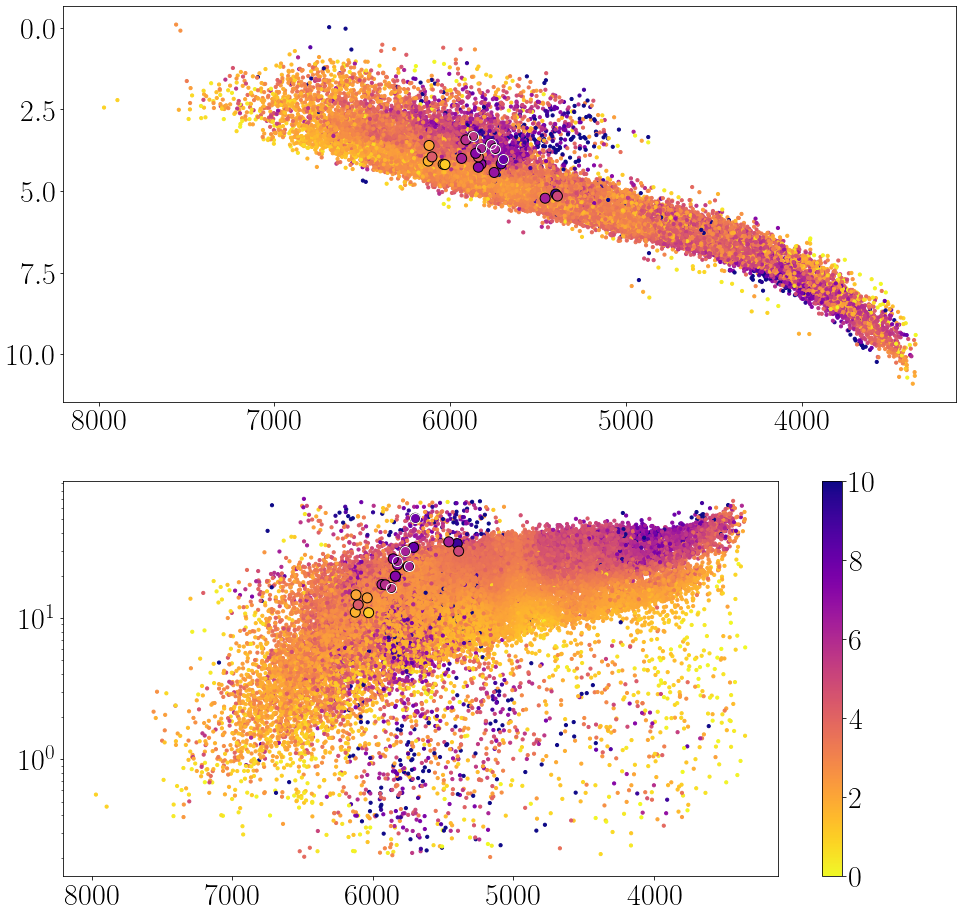

In [45]:
kics = [6196457, 6521045, 8349582, 10586004, 11244118]

fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(211)
ax1.scatter(df.color_teffs, df.abs_G, c=kin_ages, s=10, vmin=0, vmax=10, cmap="plasma_r")
ax1.scatter(ast.teff_vansaders, ast.MG, c=ast.AMP_age, s=100, edgecolor="k", vmin=0, vmax=10, cmap="plasma_r")
ax1.invert_yaxis()
ax1.invert_xaxis()

for k in kics:
    kic_mask = ast.KIC.values == k
    ax1.plot(ast.teff_vansaders[kic_mask], ast.MG[kic_mask], "o", ms=10, color="none", mec="w")

ax2 = fig.add_subplot(212)
cb = ax2.scatter(df.color_teffs, df.Prot, c=kin_ages, s=10, vmin=0, vmax=10, cmap="plasma_r")
ax2.scatter(ast.teff_vansaders, ast.period, c=ast.AMP_age, s=100, edgecolor="k", vmin=0, vmax=10, cmap="plasma_r")
ax2.invert_xaxis()
ax2.set_yscale("log")
plt.colorbar(cb)

for k in kics:
    kic_mask = ast.KIC.values == k
    ax2.plot(ast.teff_vansaders[kic_mask], ast.period[kic_mask], "o", ms=10, color="none", mec="w")

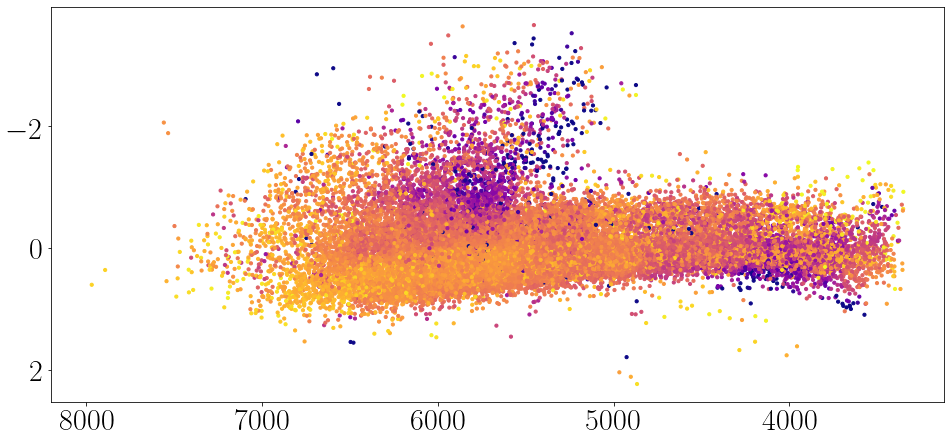

In [46]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(211)

mc = df.color_teffs.values < 8000
p = np.polyfit(df.color_teffs.values[mc], df.abs_G.values[mc], 5)

# ax1.scatter(df.color_teffs, df.abs_G, c=kin_ages, s=10, vmin=0, vmax=10, cmap="plasma_r")
ax1.scatter(df.color_teffs, df.abs_G-np.polyval(p, df.color_teffs), c=kin_ages, s=10, vmin=0, vmax=10, cmap="plasma_r")

xs = np.linspace(8000, 3000, 100)
# plt.plot(xs, np.polyval(p, xs))
ax1.invert_yaxis()
ax1.invert_xaxis()

In [48]:
G = df.abs_G.values
aG = ast.MG.values
G = df.abs_G.values - np.polyval(p, df.color_teffs)
aG = ast.MG.values - np.polyval(p, ast.teff_vansaders.values)
wG = wd.abs_G.values
wG = wd.abs_G.values - np.polyval(p, wd.color_teffs.values)

Calculate dispersions for asteroseismic, white dwarf and cluster stars. Some by-hand chi^2 minimization has gone into selecting bin sizes here.

In [162]:
astero_disp = calc_dispersion_target(ast.teff_vansaders.values, np.log10(ast.period.values), aG,
                                     df.color_teffs, np.log10(df.Prot.values), G, df.all_vz.values,
                                     350, .25, .4)

100%|██████████| 21/21 [00:00<00:00, 901.64it/s]


In [163]:
wd_disp = calc_dispersion_target(wd.color_teffs.values, np.log10(wd.prot.values), wG,
                                 df.color_teffs, np.log10(df.Prot.values), G, df.all_vz.values,
#                                  350, .25, .4)
                                 200, .5, .1)

100%|██████████| 2/2 [00:00<00:00, 462.85it/s]


In [164]:
bench_disp = calc_dispersion_target_2D(benchmark.teff.values, np.log10(benchmark.prot.values),
                                       df.color_teffs, np.log10(df.Prot.values), df.all_vz.values,
                                       200, .2)
#                                        350, .25)
cluster_disp = calc_dispersion_target_2D(clusters.TEFF.values, np.log10(clusters.PROT.values),
                                         df.color_teffs, np.log10(df.Prot.values), df.all_vz.values,
#                                          350, .25)
                                         400, .14)

100%|██████████| 79/79 [00:00<00:00, 1025.25it/s]


Calculate the period that every asteroseismic star SHOULD have if it obeys gyrochronology. Remove stars that are off by rotation periods of 5 days or more.

In [165]:
pred_period = 10**gk_rotation_model(np.log10(ast.AMP_age.values*1e9), ast.phot_bp_mean_mag - ast.phot_rp_mean_mag)
diff = (abs(pred_period - ast.period.values))
m = diff < 5

Here's where I test chi^2 and convert dispersions to kinematic ages.

In [166]:
def chi2(y1, y2, yerr):
    return sum((y1 - y2)**2/yerr**2)

astero_kin_age = av.v_to_age(astero_disp, p_mr)
wd_kin_age = av.v_to_age(wd_disp, p_mr)
bench_kin_age = av.v_to_age(bench_disp, p_mr)
cluster_kin_age = av.v_to_age(cluster_disp, p_mr)

print(chi2(wd_kin_age, wd.age_wd, np.ones_like(wd_kin_age)))
# print(chi2(cluster_kin_age, clusters.AGE.values*1e-3, np.ones_like(cluster_kin_age)))
# print(chi2(bench_kin_age, benchmark.age, np.ones_like(bench_kin_age)))
# print(chi2(astero_kin_age, ast.AMP_age, np.ones_like(astero_kin_age)))

0.17811324792536826


Combine the "ast" and "bench" data frames as the "bench" stars are also asteroseismic.

In [167]:
astero_ages = np.concatenate((ast.AMP_age.values[m], benchmark.age.values))
astero_kin_ages = np.concatenate((astero_kin_age[m], bench_kin_age))
astero_age_errs = np.concatenate((ast.AMP_age_err[m], np.ones_like(bench_kin_age)))

Plot a comparison. Color asteroseismic stars by the difference between predicted and measured period -- see how lots of stars in that bottom cluster have a large delta. Some stars on the 1:1 line have a large delta too but I think that's because they're evolved! (You can see this when you plot logg as color on line 8). What plot can we make to demonstrate all of this better?

Text(0, 0.5, '$\\mathrm{Kinematic~age~[Gyr]}$')

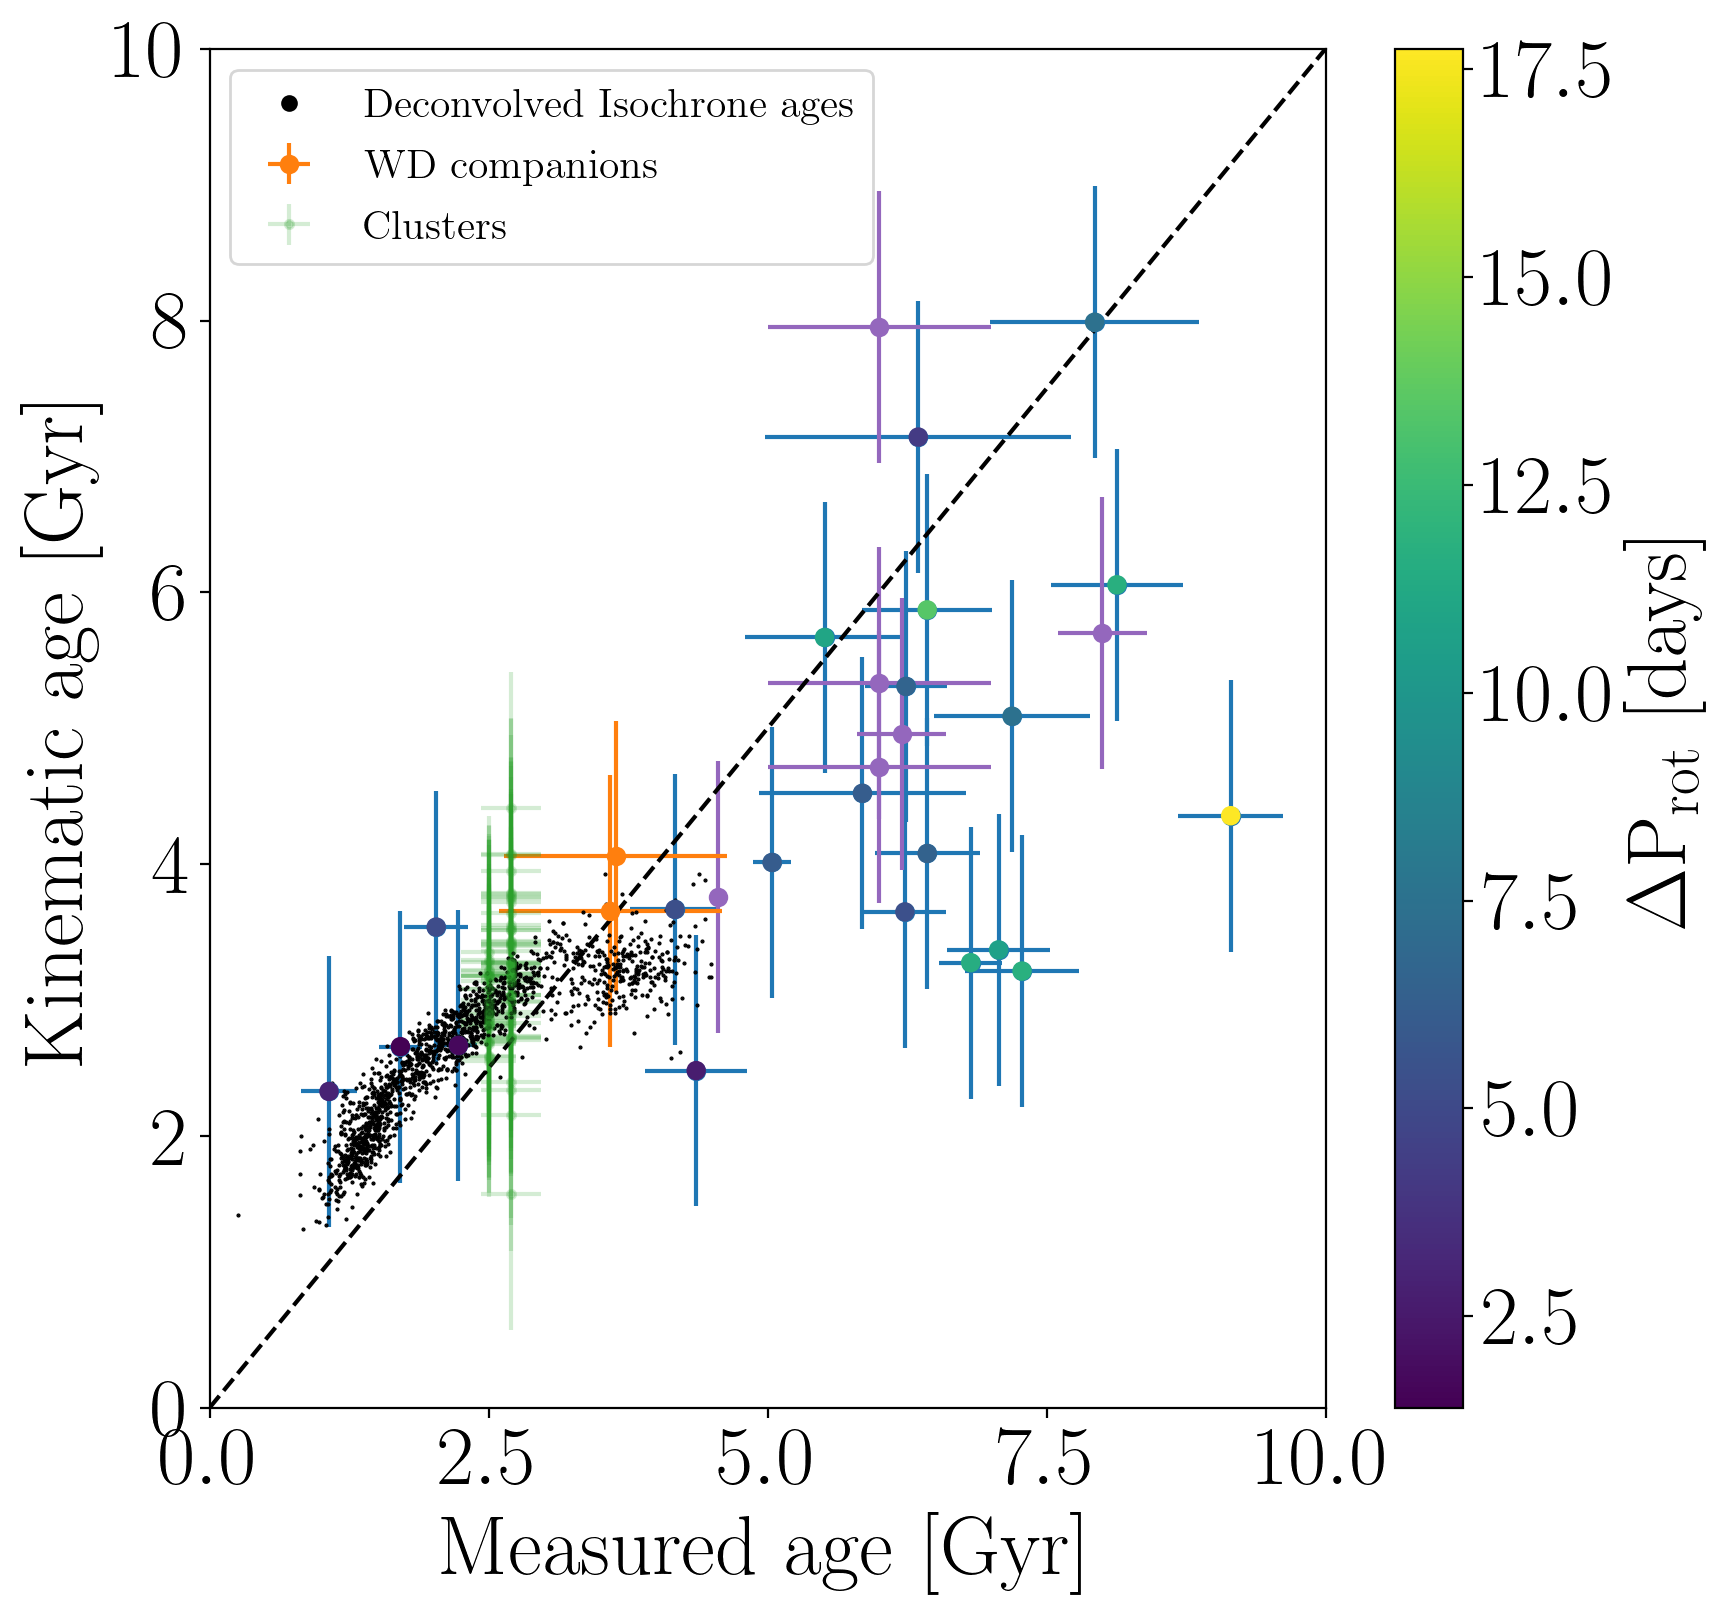

In [171]:
fig = plt.figure(figsize=(9, 9), dpi=200)
ax = fig.add_subplot(111)

# Asteroseismic stars.
m2 = astero_kin_age > 5  # Add old asteroseismic stars back in.
plt.errorbar(ast.AMP_age, astero_kin_age, xerr=ast.AMP_age_err, yerr=np.ones_like(astero_kin_age), fmt="C0o", label="")
plt.errorbar(benchmark.age, bench_kin_age, xerr=benchmark.age_err, yerr=np.ones_like(bench_kin_age), fmt="C4o", label="")

plt.scatter(ast.AMP_age, astero_kin_age, c=diff, zorder=10)
# plt.scatter(ast.AMP_age, astero_kin_age, c=ast.AMP_logg, zorder=10)  # Uncomment this line to plot with logg as the colorbar.
plt.colorbar(label="$\Delta \mathrm{P_{rot}~[days]}$")

ax.errorbar(wd.age_wd, wd_kin_age, yerr=np.ones_like(wd_kin_age), xerr=np.ones_like(wd_kin_age), fmt="C1o",
            label="$\mathrm{WD~companions}$")

xd = pd.read_csv("../../data/xd_results.csv")
xm = (xd.iso_age.values < 4.5) & (xd.kin_age.values < 4) 
ax.plot(xd.iso_age.values[xm], xd.kin_age.values[xm], "k.", ms=1,
        label="$\mathrm{Deconvolved~Isochrone~ages}$")


ax.errorbar(clusters.AGE*1e-3, cluster_kin_age, xerr=clusters.AGE*1e-4, yerr=np.ones_like(cluster_kin_age),
             fmt="C2.", alpha=.2, label="$\mathrm{Clusters}$")

leg = plt.legend()
leg.legendHandles[0]._legmarker.set_markersize(10)

xs = np.linspace(0, 10, 100)
ax.plot(xs, xs, "k", ls="--")
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel("$\mathrm{Measured~age~[Gyr]}$")
ax.set_ylabel("$\mathrm{Kinematic~age~[Gyr]}$")

Now plot the same again with the weakened stars taken out, but the old (evolved) stars put back.

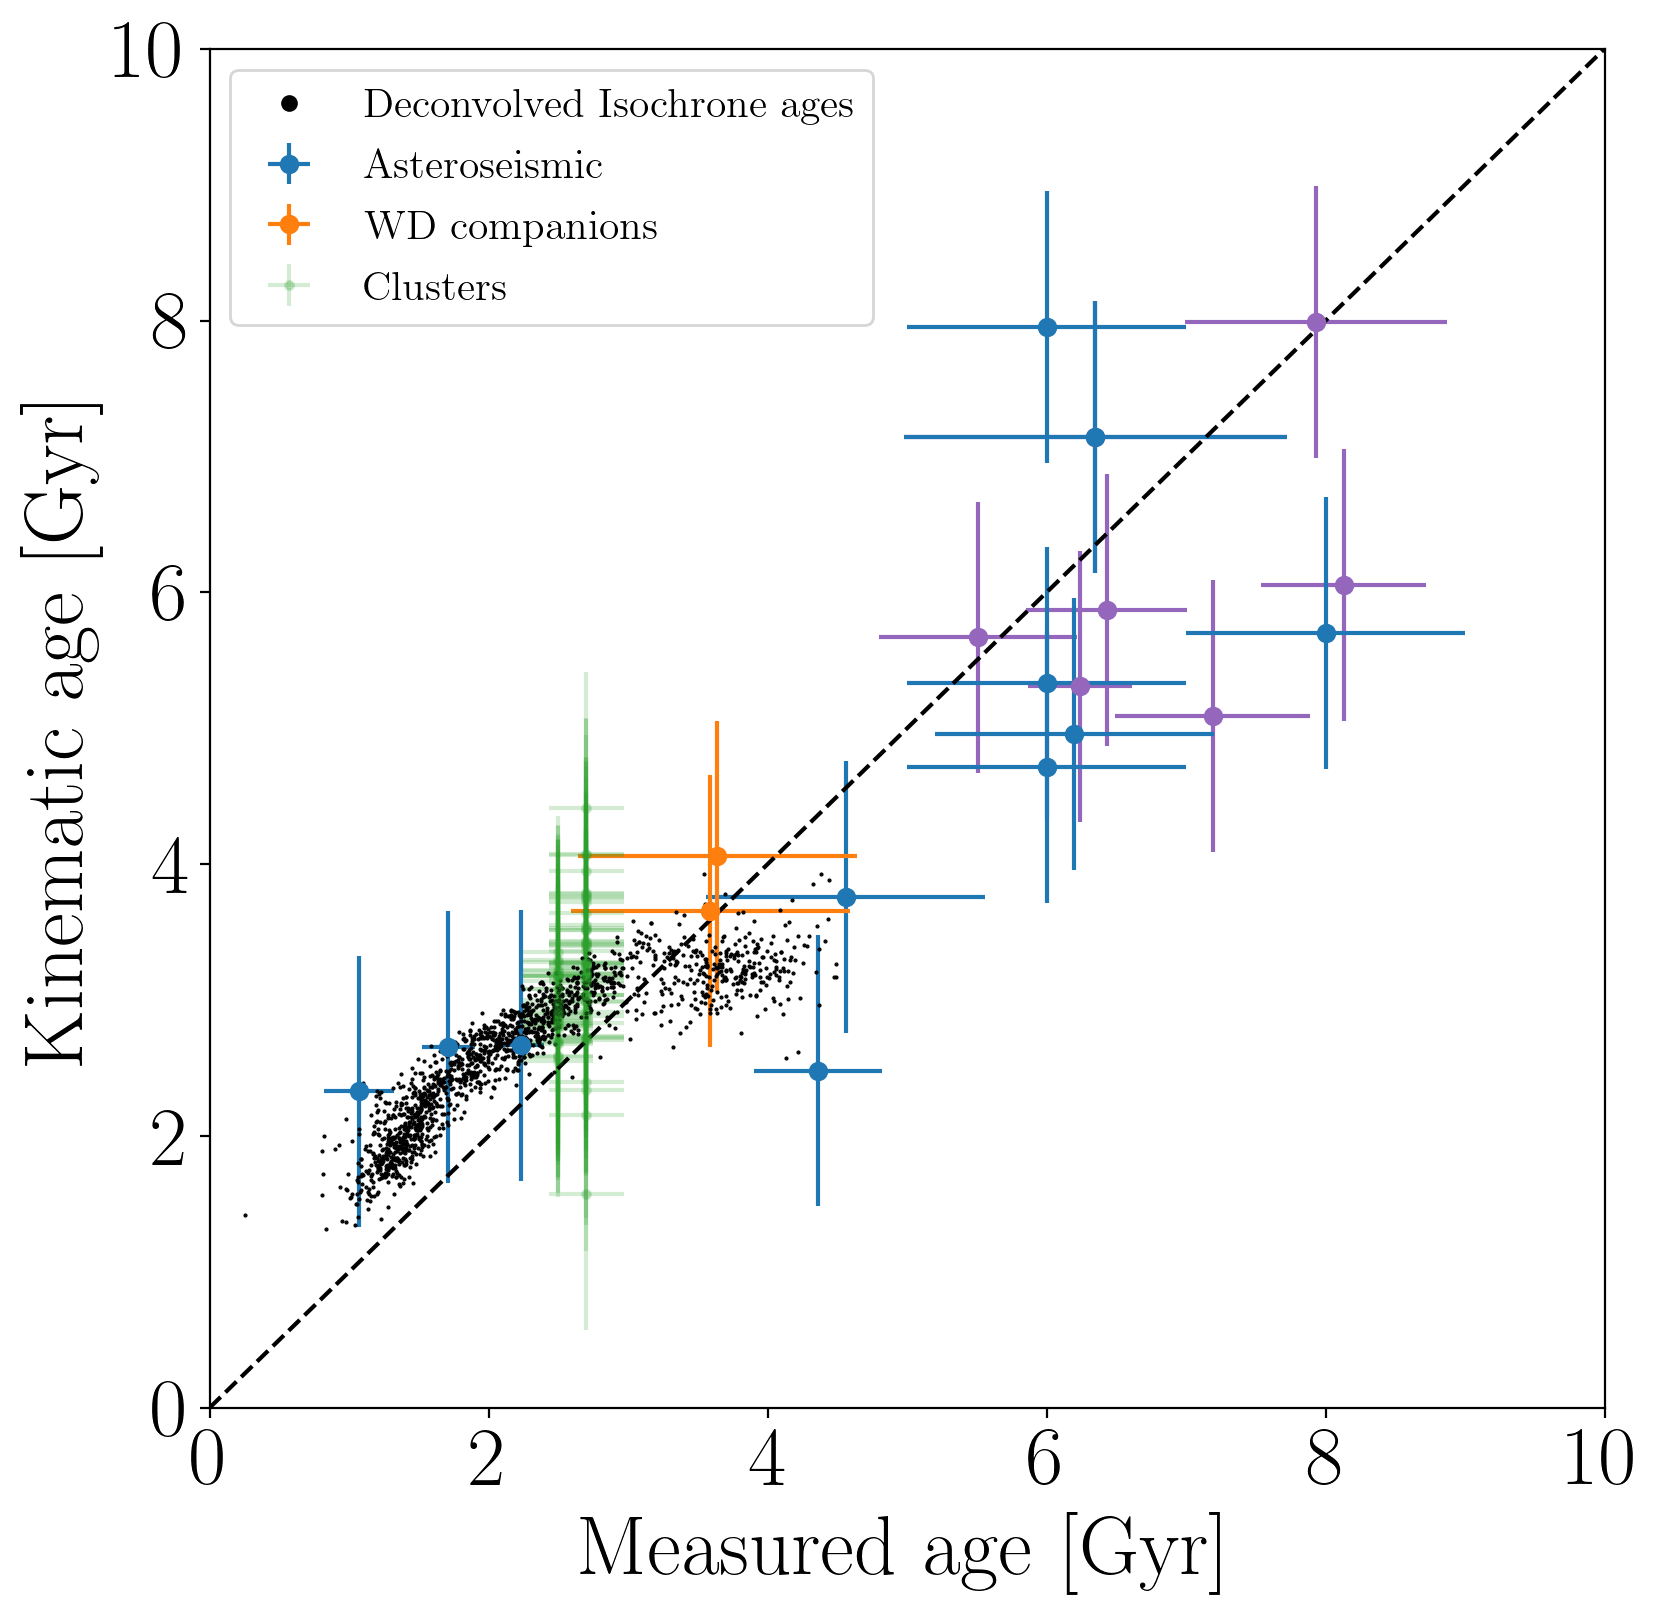

In [169]:
fig = plt.figure(figsize=(9, 9), dpi=200)
ax = fig.add_subplot(111)

# Asteroseismic stars.
m2 = astero_kin_age > 5  # Add old asteroseismic stars back in.
# m2 = ast.AMP_logg.values < 4.15  # Adding low-gravity stars can work almost as well
ax.errorbar(ast.AMP_age[m2], astero_kin_age[m2], xerr=ast.AMP_age_err[m2], yerr=np.ones_like(astero_kin_age)[m2], fmt="C4o", label="")
ax.errorbar(astero_ages, astero_kin_ages, xerr=astero_age_errs, yerr=np.ones_like(astero_kin_ages), fmt="C0o",
            label="$\mathrm{Asteroseismic}$")

ax.errorbar(wd.age_wd, wd_kin_age, yerr=np.ones_like(wd_kin_age), xerr=np.ones_like(wd_kin_age), fmt="C1o",
            label="$\mathrm{WD~companions}$")

xd = pd.read_csv("../../data/xd_results.csv")
xm = (xd.iso_age.values < 4.5) & (xd.kin_age.values < 4) 
ax.plot(xd.iso_age.values[xm], xd.kin_age.values[xm], "k.", ms=1,
        label="$\mathrm{Deconvolved~Isochrone~ages}$")


ax.errorbar(clusters.AGE*1e-3, cluster_kin_age, xerr=clusters.AGE*1e-4, yerr=np.ones_like(cluster_kin_age),
             fmt="C2.", alpha=.2, label="$\mathrm{Clusters}$")

leg = plt.legend()
leg.legendHandles[0]._legmarker.set_markersize(10)

xs = np.linspace(0, 10, 100)
ax.plot(xs, xs, "k", ls="--")
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel("$\mathrm{Measured~age~[Gyr]}$")
ax.set_ylabel("$\mathrm{Kinematic~age~[Gyr]}$")
plt.savefig("age_comparison")
plt.savefig("age_comparison.pdf")

Playing around with plotting gyrochrones (not important).

5897.874466291198
6191.250403648134
[ 6116048 10963065 11401755]


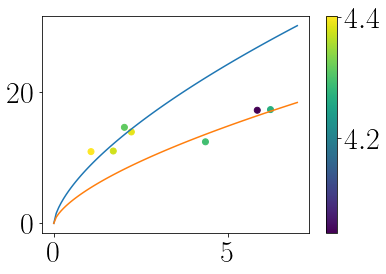

In [76]:
xs_bprp = .78
xs_teff = bprp_to_teff(xs_bprp)
print(xs_teff)
ages = np.linspace(0, 7, 100)
prots = 10**gk_rotation_model(np.log10(ages*1e9), xs_bprp)
plt.plot(ages, prots)

xs_bprp = .69
xs_teff = bprp_to_teff(xs_bprp)
print(xs_teff)
prots = 10**gk_rotation_model(np.log10(ages*1e9), xs_bprp)
plt.plot(ages, prots)

tm = (5900 < ast.teff_vansaders.values) & (ast.teff_vansaders.values < 6200)
plt.scatter(ast.AMP_age.values[tm], ast.period.values[tm], c=ast.AMP_logg.values[tm])
plt.colorbar()

# low = ast.AMP_age.values[tm] > 5
# print(ast.KIC.values[tm][low])

print(ast.KIC.values[tm][ast.AMP_age.values[tm]> 3.5])

5594.398729557282
5897.874466291198
[12069424 12069449  3656476  5184732  6196457  6521045  7680114  9098294
 11244118]


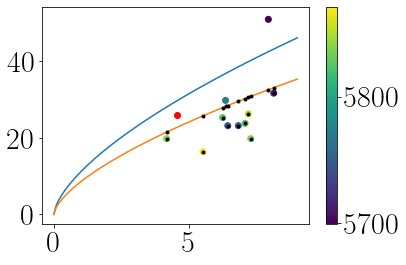

In [77]:
xs_bprp = .88
xs_teff = bprp_to_teff(xs_bprp)
print(xs_teff)
ages = np.linspace(0, 9, 100)
prots = 10**gk_rotation_model(np.log10(ages*1e9), xs_bprp)
plt.plot(ages, prots)

xs_bprp = .78
xs_teff = bprp_to_teff(xs_bprp)
print(xs_teff)
prots = 10**gk_rotation_model(np.log10(ages*1e9), xs_bprp)
plt.plot(ages, prots)

tm = (5600 < ast.teff_vansaders.values) & (ast.teff_vansaders.values < 5900)
plt.plot(4.56, 26, "ro")
plt.scatter(ast.AMP_age.values[tm], ast.period.values[tm], c=ast.teff_vansaders.values[tm])
plt.colorbar()

# Get rid of those anomalous stars
axe_prots = 10**gk_rotation_model(np.log10(ast.AMP_age.values[tm]*1e9), xs_bprp)
plt.plot(ast.AMP_age.values[tm], axe_prots, "k.")
axe_mask = ast.period.values[tm] < axe_prots
_axe = ast.KIC.values[tm][axe_mask]
plt.plot(ast.AMP_age.values[tm][axe_mask], ast.period.values[tm][axe_mask], "k.")
print(_axe)

5113.0077549724165
5397.007165759355
[8006161]


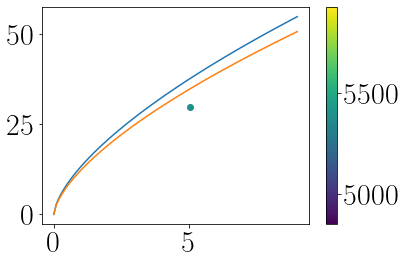

In [78]:
xs_bprp = 1.06
xs_teff = bprp_to_teff(xs_bprp)
print(xs_teff)
ages = np.linspace(0, 9, 100)
prots = 10**gk_rotation_model(np.log10(ages*1e9), xs_bprp)
plt.plot(ages, prots)

xs_bprp = .95
xs_teff = bprp_to_teff(xs_bprp)
print(xs_teff)
prots = 10**gk_rotation_model(np.log10(ages*1e9), xs_bprp)
plt.plot(ages, prots)

tm = (5100 < ast.teff_vansaders.values) & (ast.teff_vansaders.values < 5400)
plt.scatter(ast.AMP_age.values[tm], ast.period.values[tm], c=ast.teff_vansaders.values[tm])
plt.colorbar()
print(ast.KIC.values[tm])

In [ ]:
axe = np.array([8006161, 12069424, 12069449, 3656476, 5184732, 6196457, 6521045, 7680114, 9098294, 11244118, 6116048,
                10963065, 11401755])